In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import numpy as np
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Read the CSV file
df = pd.read_csv('R2.csv')
df.head(105)

,Test Cases Name,Test Cases,Requirements,Core Business Functions,Allied Atomic Functions,Technical Functions,Enabling Operations,Encapsulated Functions,Release2/Fault Count,Fault Severity,Dependency,Verdict
0,test case addition failed in tester's log test...,T1,R10,10,0,0,0,0,0,0,3,1
1,add bugs in tester's log test suite,T2,R10,10,0,0,0,0,0,0,3,1
2,add personal projects in tester's portfolio,T3,R9,10,0,0,0,0,0,0,3,1
3,add requirement button on client project initi...,T4,R6,10,0,0,0,0,0,0,3,1
4,add skills in tester's portfolio,T5,R9,10,0,0,0,0,0,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
94,tester's dashboard progress button,T95,R14,0,0,6,0,0,1,1,3,0
95,tester's profile updation,T96,R13,0,0,0,0,2,0,0,3,1
96,update uploaded resume,T97,R13,0,0,0,0,2,0,0,3,1
97,upload resume button in tester's portfolio,T98,R9,10,0,0,0,0,1,1,3,0


In [3]:
# Get the shape of the DataFrame
shape = df.shape
# Print the number of rows and columns
print("Number of rows:", shape[0])
print("Number of columns:", shape[1])

df.columns

Number of rows: 99
Number of columns: 12


Index(['Test Cases Name', 'Test Cases ', 'Requirements',
       'Core Business Functions', 'Allied Functions', 'Technical Functions',
       'Atomic Operations', 'Encapsulated Functions', 'Release2/Fault Count',
       'Fault Severity', 'Dependency', 'Verdict'],
      dtype='object')

In [4]:
# Extract the test cases from the CSV
test_cases = df['Test Cases '] +', ' + df['Requirements']

# Extract the feature columns from the CSV
feature_columns = df.columns[3:]

# Create a dictionary to store the features and their values
features = {}
for feature in feature_columns:
    features[feature] = df[feature].values

In [5]:
# Define the environment
class TestPrioritizationEnv:
    def __init__(self, test_cases, features):
        self.test_cases = test_cases
        self.features = features
        self.state_size = len(features)  # Change state_size to match the number of features
        self.action_size = len(test_cases)
        self.current_test = 0

    def reset(self):
        self.current_test = 0
        return self.get_state()
    
    def get_state(self):
        if self.current_test < len(self.test_cases):
            state = [self.features[feature][self.current_test] for feature in self.features]
            return state
        else:
           
            return None

    def step(self, action):
        test_case = self.test_cases[self.current_test]
        reward = self.calculate_business_value(test_case)
        self.current_test += 1
        done = self.current_test == len(self.test_cases)
        return self.get_state(), reward, done

    def calculate_business_value(self, test_case):
        index = self.test_cases.tolist().index(test_case)
        business_value = sum([self.features[feature][index] for feature in self.features])
        return business_value
    



In [6]:
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount factor
        self.learning_rate = learning_rate
        self.model = self.build_model()
    
    def build_model(self):
        model = Sequential()
        model.add(Dense(self.state_size, input_dim=self.state_size, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

  
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))  

    
    def act(self, state):
        state = np.array(state).reshape(1, -1)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])
 
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = np.array(state)  
            state = np.reshape(state, [1, self.state_size])

            if next_state is not None:
                next_state = np.array(next_state)  
                next_state = np.reshape(next_state, [1, self.state_size])
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            else:
               
                target = reward  

            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)


    def train(self, env, episodes, batch_size):
        for episode in range(episodes):
            state = env.reset()
            total_reward = 0
            done = False
            while not done:
                action = self.act(state)
                next_state, reward, done = env.step(action)
                self.remember(state, action, reward, next_state, done)
                total_reward += reward
                state = next_state

            if len(self.memory) > batch_size:
                self.replay(batch_size)

    def get_prioritized_test_cases(self, env):
        prioritized_test_cases = []
        state = env.reset()
        done = False
        while not done:
            action = self.act(state)
            test_case = env.test_cases[env.current_test]
            reward = env.calculate_business_value(test_case)
            prioritized_test_cases.append((test_case, reward))
            next_state, _, done = env.step(action)
            state = next_state
        return prioritized_test_cases

In [7]:
# Create the environment with the test cases and features
env = TestPrioritizationEnv(test_cases, features)

# Create the DQN agent
state_size = env.state_size
action_size = env.action_size
agent = DQNAgent(state_size, action_size)

# Train the DQN agent
episodes =10 
batch_size = 32
agent.train(env, episodes, batch_size)

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 37ms/step


In [8]:
# Calculate the business value and prioritize the test cases
prioritized_test_cases = []
for test_case in test_cases:
    business_value = env.calculate_business_value(test_case)
    prioritized_test_cases.append((test_case, business_value))

# Sort the test cases based on business value (in descending order)
prioritized_test_cases.sort(key=lambda x: x[1], reverse=True)

# Print the prioritized test cases
for test_case, business_value in prioritized_test_cases:
    print(f"Test Case: {test_case}, Business Value: {business_value}")

Test Case: T40, R6, Business Value: 16
Test Case: T98, R9, Business Value: 15
Test Case: T1, R10, Business Value: 14
Test Case: T2, R10, Business Value: 14
Test Case: T3, R9, Business Value: 14
Test Case: T4, R6, Business Value: 14
Test Case: T5, R9, Business Value: 14
Test Case: T6, R9, Business Value: 14
Test Case: T7, R7, Business Value: 14
Test Case: T8, R7, Business Value: 14
Test Case: T12, R7, Business Value: 14
Test Case: T13, R7, Business Value: 14
Test Case: T26, R6, Business Value: 14
Test Case: T49, R6, Business Value: 14
Test Case: T77, R10, Business Value: 14
Test Case: T80, R10, Business Value: 14
Test Case: T83, R10, Business Value: 14
Test Case: T87, R4, Business Value: 14
Test Case: T99, R9, Business Value: 14
Test Case: T18, R3, Business Value: 12
Test Case: T37, R1, Business Value: 12
Test Case: T43, R1, Business Value: 12
Test Case: T44, R3, Business Value: 12
Test Case: T54, R16, Business Value: 12
Test Case: T55, R16, Business Value: 12
Test Case: T56, R16, Busin

In [9]:
# Calculate the business value and prioritize the test cases
prioritized_test_cases = []
prioritized_requirements = set()
for test_case in test_cases:
    business_value = env.calculate_business_value(test_case)
    requirement = test_case.split(',')[1].strip()
    if requirement not in prioritized_requirements:
        prioritized_test_cases.append((test_case, business_value))
        prioritized_requirements.add(requirement)

# Sort the test cases based on business value (in descending order)
prioritized_test_cases.sort(key=lambda x: x[1], reverse=True)

# Print the prioritized test cases
for test_case, business_value in prioritized_test_cases:
    print(f"Test Case: {test_case}, Business Value: {business_value}")

Test Case: T1, R10, Business Value: 14
Test Case: T3, R9, Business Value: 14
Test Case: T4, R6, Business Value: 14
Test Case: T7, R7, Business Value: 14
Test Case: T87, R4, Business Value: 14
Test Case: T18, R3, Business Value: 12
Test Case: T37, R1, Business Value: 12
Test Case: T15, R5, Business Value: 11
Test Case: T53, R16, Business Value: 11
Test Case: T14, R14, Business Value: 10
Test Case: T17, R2, Business Value: 10
Test Case: T36, R8, Business Value: 10
Test Case: T11, R11, Business Value: 8
Test Case: T9, R12, Business Value: 6
Test Case: T16, R13, Business Value: 5


In [10]:
# Scale the feature values using MinMaxScaler
scaler = MinMaxScaler()
for feature in feature_columns:
    feature_values = features[feature].reshape(-1, 1)
    scaled_values = scaler.fit_transform(feature_values).flatten()
    features[feature] = scaled_values
# Calculate the business value and prioritize the test cases
prioritized_test_cases = []
for test_case in test_cases:
    business_value = env.calculate_business_value(test_case)
    prioritized_test_cases.append((test_case, business_value))

# Sort the test cases based on business value (in descending order)
prioritized_test_cases.sort(key=lambda x: x[1], reverse=True)

# Print the prioritized test cases
for test_case, business_value in prioritized_test_cases:
    print(f"Test Case: {test_case}, Business Value: {business_value}")

Test Case: T30, R11, Business Value: 3.6666666666666665
Test Case: T32, R11, Business Value: 3.6666666666666665
Test Case: T40, R6, Business Value: 3.6666666666666665
Test Case: T15, R5, Business Value: 3.3333333333333335
Test Case: T95, R14, Business Value: 3.3333333333333335
Test Case: T98, R9, Business Value: 3.3333333333333335
Test Case: T1, R10, Business Value: 3.0
Test Case: T2, R10, Business Value: 3.0
Test Case: T3, R9, Business Value: 3.0
Test Case: T4, R6, Business Value: 3.0
Test Case: T5, R9, Business Value: 3.0
Test Case: T6, R9, Business Value: 3.0
Test Case: T7, R7, Business Value: 3.0
Test Case: T8, R7, Business Value: 3.0
Test Case: T9, R12, Business Value: 3.0
Test Case: T10, R12, Business Value: 3.0
Test Case: T11, R11, Business Value: 3.0
Test Case: T12, R7, Business Value: 3.0
Test Case: T13, R7, Business Value: 3.0
Test Case: T14, R14, Business Value: 3.0
Test Case: T18, R3, Business Value: 3.0
Test Case: T19, R13, Business Value: 3.0
Test Case: T26, R6, Business 

In [11]:
# Calculate the business value and prioritize the test cases
prioritized_test_cases = []
prioritized_requirements = set()
for test_case in test_cases:
    business_value = env.calculate_business_value(test_case)
    requirement = test_case.split(',')[1].strip()
    if requirement not in prioritized_requirements:
        prioritized_test_cases.append((test_case, business_value))
        prioritized_requirements.add(requirement)

# Sort the test cases based on business value (in descending order)
prioritized_test_cases.sort(key=lambda x: x[1], reverse=True)

# Print the prioritized test cases
for test_case, business_value in prioritized_test_cases:
    print(f"Test Case: {test_case}, Business Value: {business_value}")

Test Case: T15, R5, Business Value: 3.3333333333333335
Test Case: T1, R10, Business Value: 3.0
Test Case: T3, R9, Business Value: 3.0
Test Case: T4, R6, Business Value: 3.0
Test Case: T7, R7, Business Value: 3.0
Test Case: T9, R12, Business Value: 3.0
Test Case: T11, R11, Business Value: 3.0
Test Case: T14, R14, Business Value: 3.0
Test Case: T18, R3, Business Value: 3.0
Test Case: T36, R8, Business Value: 3.0
Test Case: T87, R4, Business Value: 3.0
Test Case: T53, R16, Business Value: 2.875
Test Case: T16, R13, Business Value: 2.5
Test Case: T37, R1, Business Value: 2.4
Test Case: T17, R2, Business Value: 2.375


In [1]:
# Calculate NAPFD
total_faults_in_prioritized_test_cases = 6
total_faults_in_normal_test_cases = 7
p = total_faults_in_prioritized_test_cases / total_faults_in_normal_test_cases

total_faults_found = 6
num_faults = 7
total_test_cases = 49
napfd = p - (total_faults_found / (num_faults * total_test_cases)) + (p / (2 * total_test_cases))
print("NAPFD:", napfd)


NAPFD: 0.8483965014577258


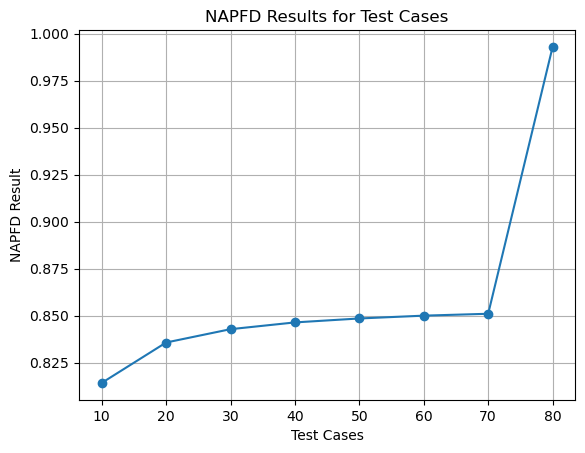

In [2]:
import matplotlib.pyplot as plt

# Sample test case values and napfd results
test_cases= [10, 20, 30, 40, 50, 60, 70, 80]
napfd_results = [0.8142, 0.8357, 0.8428, 0.8464, 0.8485, 0.85, 0.851, 0.993]

# Plotting the graph
plt.plot(test_cases, napfd_results, marker='o')
plt.xlabel('Test Cases')
plt.ylabel('NAPFD Result')
plt.title('NAPFD Results for Test Cases')
plt.grid(True)
plt.show()